# Модель ТВП участков ГТС

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import datetime

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

# Модели временных рядов
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ExpandingWindowSplitter

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# Метрики
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# plt.style.use('ggplot')
%config IPCompleter.greedy=True # ускоряет автокомплит
plt.rcParams['figure.figsize'] = [10, 5] # задает размер графиков
plt.rcParams['figure.dpi'] = 200 # устанавливает разрешение (при экспорте можно увеличить)

 ## поля датасета

- 'sheet_name' - имя листа откуда производилось чтение информации, 
- 'line_id' - id участка, 
- 'line_name' - имя участка, 
- 'fact_month' - фактический поток в определенный месяц,
- 'tvps_with_rr' - ТВПС с учетом ремонтных работ, 
- 'tvps_without_rr' - ТВПС без учета ремонтных работ, 
- 'tvp_with_rr'- ТВП с учетом ремонтных работ, 
- 'tvp_without_rr' - ТВП без учета ремонтных работ,
- 'datetime - метка времени (год, месяц)'

In [2]:
df = pd.read_csv('./Passports_data.csv', sep='\t', encoding='utf-8',index_col='Unnamed: 0')
df['date_time'] = pd.to_datetime(df['time'])

df = df.drop(['time'], axis=1)
df = df.sort_values(by=['date_time'])

In [3]:
df.columns

Index(['sheet_name', 'line_id', 'line_name', 'fact_day_month', 'tvps_with_rr',
       'tvps_without_rr', 'tvp_with_rr', 'tvp_without_rr', 'fact_month_sum',
       'date_time'],
      dtype='object')

In [4]:
df.shape

(46404, 10)

In [5]:
df['line_name'][1]

'КС Пуровская – КС Правохеттинская: Вход КС Пуровская'

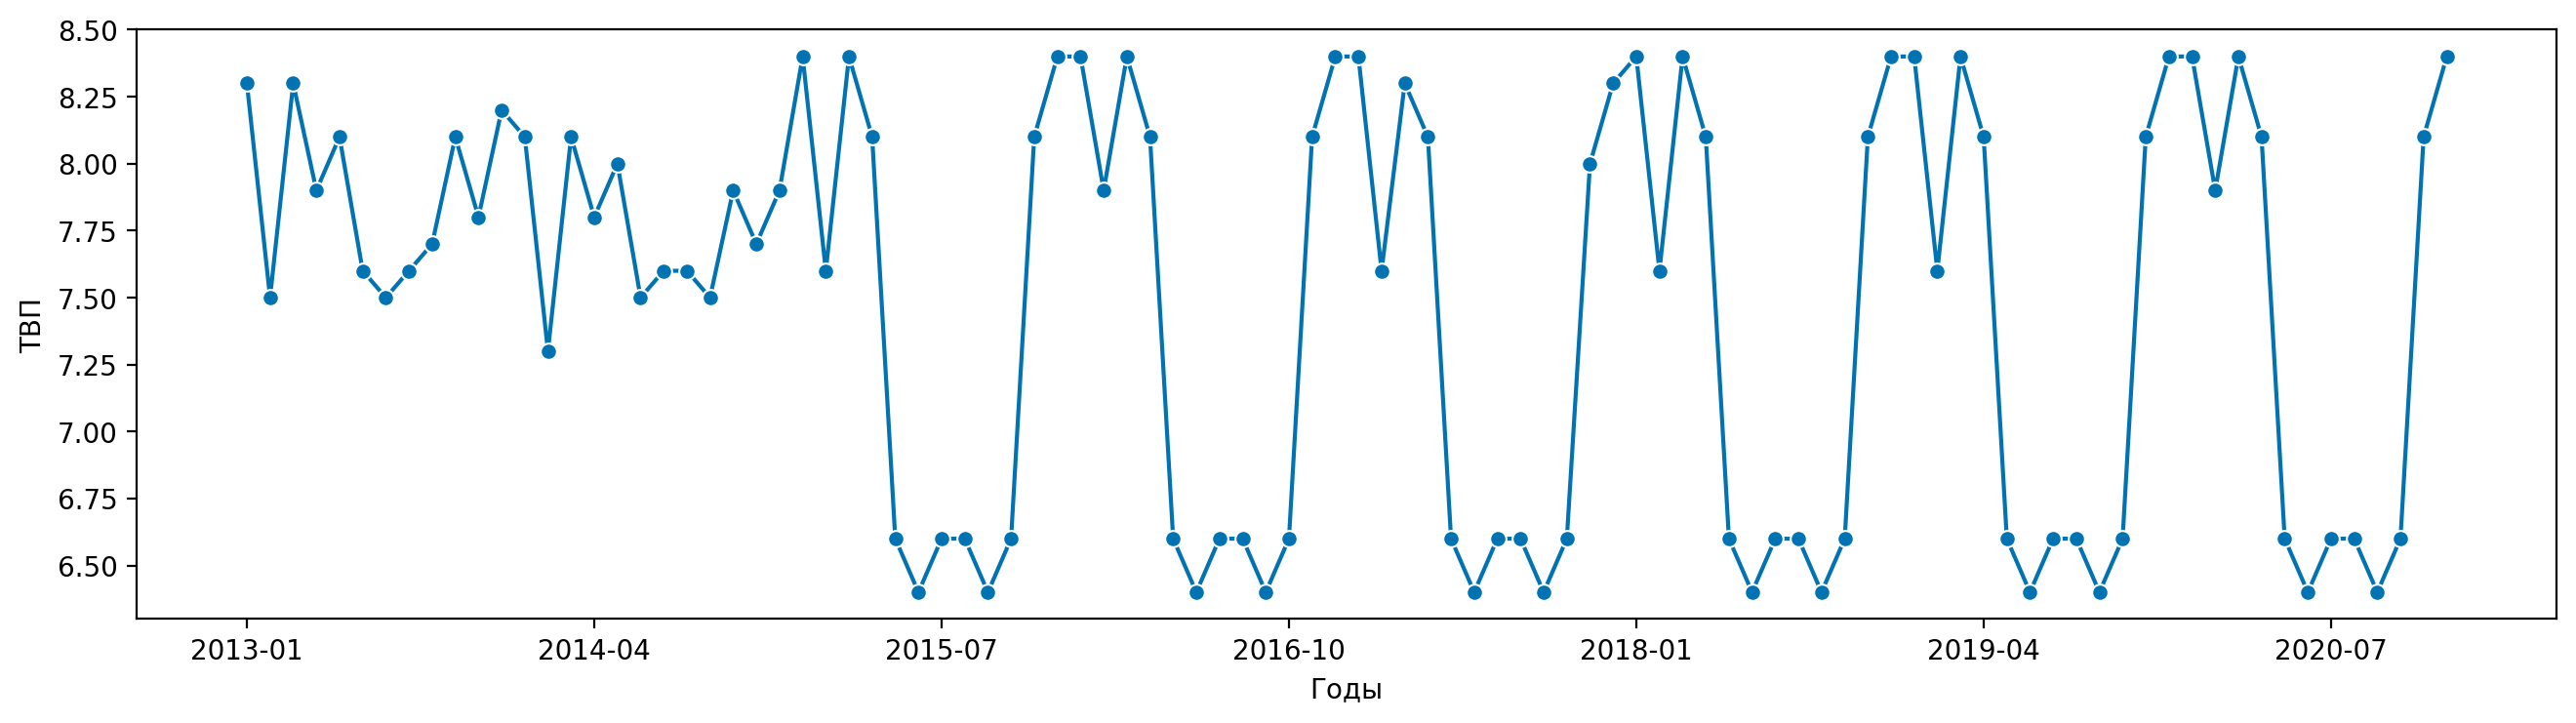

In [6]:
y = df.loc[((df['line_name']==df['line_name'][1]) &
             (df.date_time.dt.year > 2012))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
y = y.set_index('date_time')
y = pd.Series(y['tvp_without_rr'].values, index=y.index.to_period())

# #plotting for visualization
plot_series(y, y_label='ТВП', x_label='Годы');

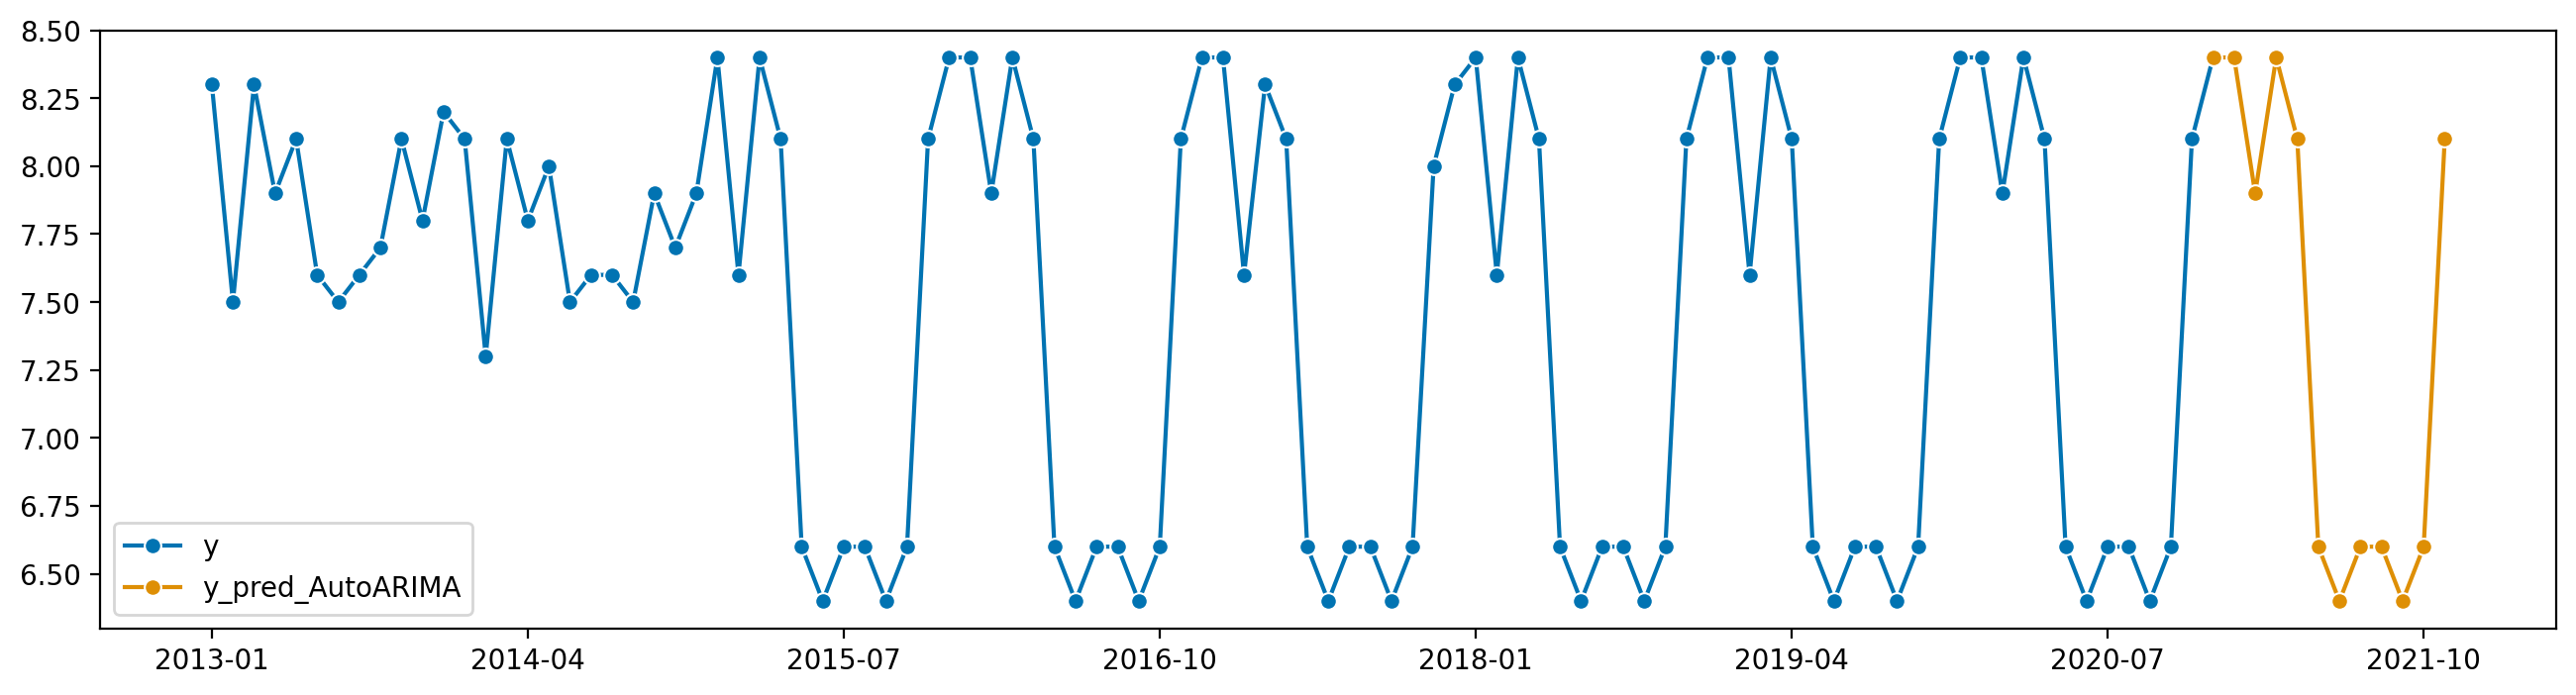

In [7]:
#Forecasting

forecast_period = 12

# y_train, y_test = temporal_train_test_split(y, test_size=forecast_period)

# fh = ForecastingHorizon(y_test.index, is_relative=False)

fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range(str(y.index[-1].year) + '-' + str(y.index[-1].month),
                                 periods=forecast_period, freq="M")), 
    is_relative=False)

# Forecasters

forecaster_AutoARIMA = AutoARIMA(sp=forecast_period, suppress_warnings=True)

# forecaster_AutoETS = AutoETS(auto=True, sp=forecast_period, n_jobs=-1)

# forecaster_NaiveForecaster = NaiveForecaster(strategy="last", sp=forecast_period)

forecaster_AutoARIMA.fit(y)
y_pred_AutoARIMA = forecaster_AutoARIMA.predict(fh)

# forecaster_AutoETS.fit(y_train)
# y_pred_AutoETS = forecaster_AutoETS.predict(fh)

# forecaster_NaiveForecaster.fit(y_train)
# y_pred_NaiveForecaster = forecaster_NaiveForecaster.predict(fh)

plot_series(y, y_pred_AutoARIMA,
            labels=["y", "y_pred_AutoARIMA"]);


Выполнен прогноз на 1 года
Выполнен прогноз на 2 года
Выполнен прогноз на 3 года
Выполнен прогноз на 4 года
Выполнен прогноз на 5 лет
Выполнен прогноз на 6 лет


ValueError: cannot reindex from a duplicate axis

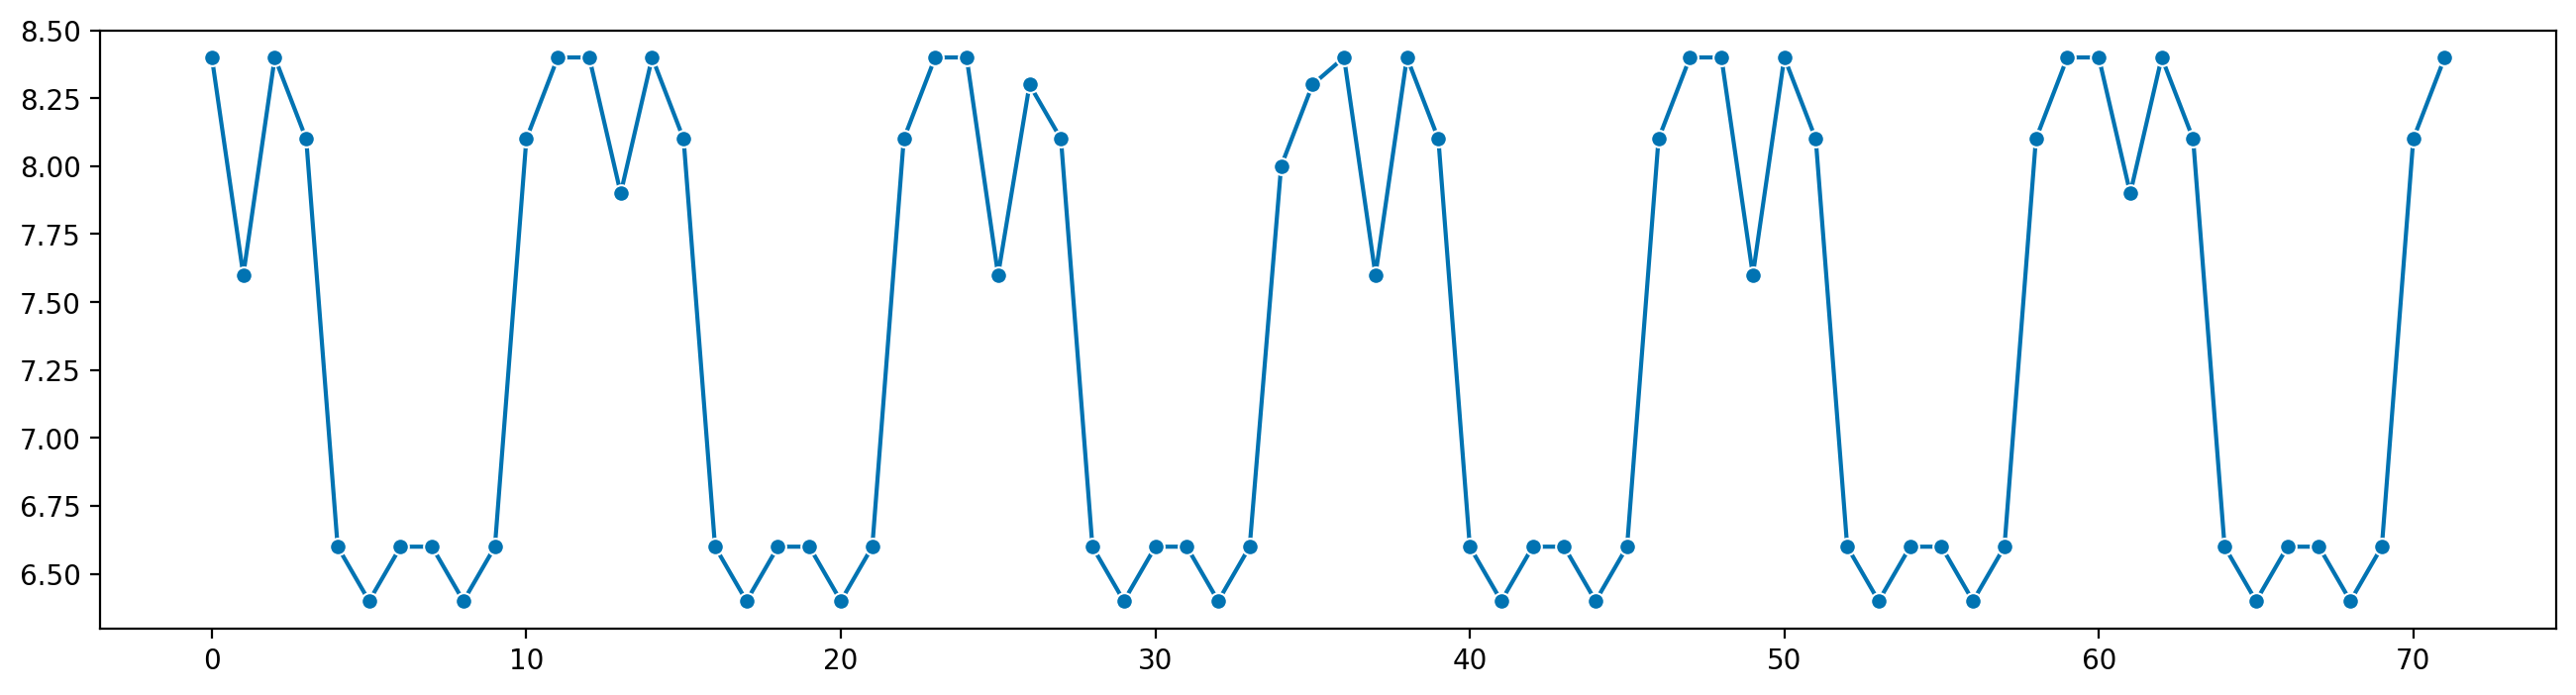

In [12]:
y = df.loc[((df['line_name']==df['line_name'][1]) &
             (df.date_time.dt.year > 2014))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
y = y.set_index('date_time')
y = pd.Series(y['tvp_without_rr'].values, index=y.index.to_period())
y_source = y.copy(deep=True)
y_pred = pd.Series()

for i in range(6):
    #Forecasting

    forecast_period = 12

    fh = ForecastingHorizon(
        pd.PeriodIndex(pd.date_range(str(y.index[-1].year) + '-' + str(y.index[-1].month),
                                     periods=forecast_period, freq="M")), 
        is_relative=False)

    # Forecasters

    forecaster_AutoARIMA = AutoARIMA(sp=forecast_period, suppress_warnings=True)

    forecaster_AutoARIMA.fit(y)
    y_pred_AutoARIMA = forecaster_AutoARIMA.predict(fh)

    y = pd.concat([y, y_pred_AutoARIMA])
    y_pred = pd.concat([y_pred, y_pred_AutoARIMA])
    
    if i < 4:
        print(f'Выполнен прогноз на {i+1} года')
    else:
        print(f'Выполнен прогноз на {i+1} лет')
plot_series(y_source, y_pred);

# Разложение на компоненты
Разложим исходный временной ряд для выделения тренда, гармонической составляющей и шума

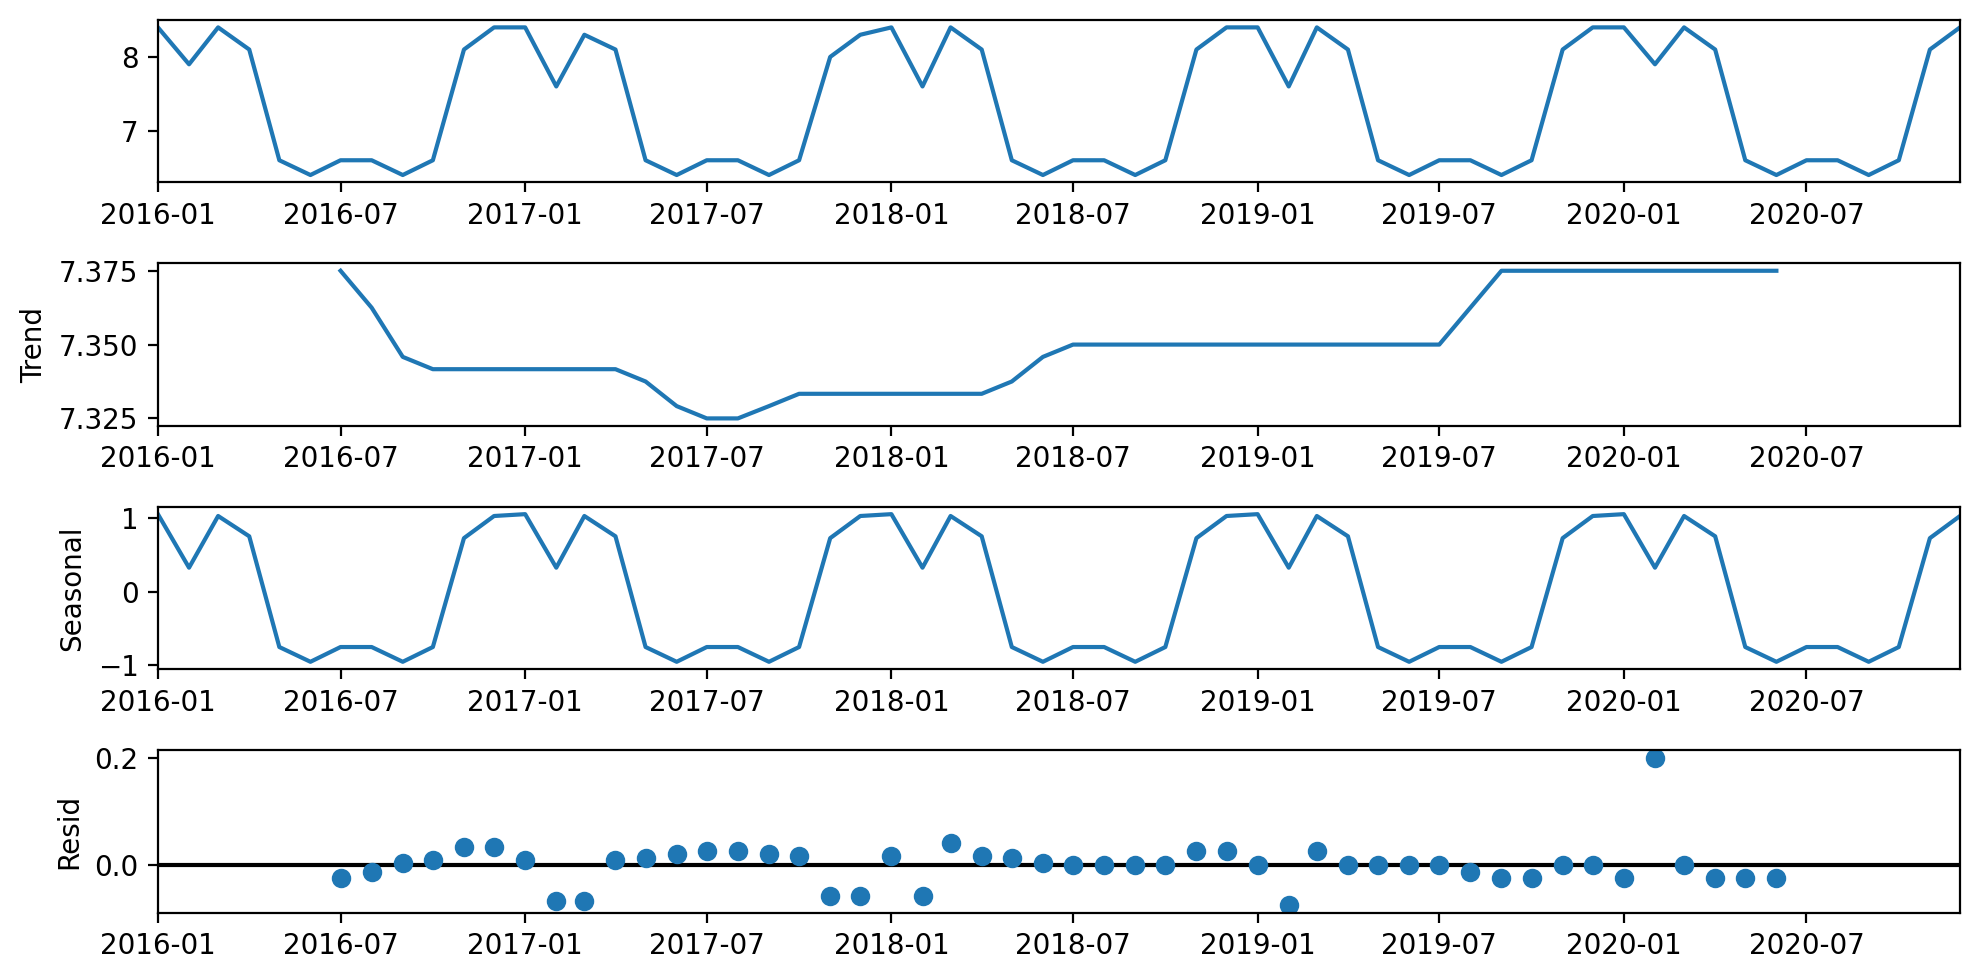

In [10]:
y = df.loc[((df['line_name']==df['line_name'][1]) &
             (df.date_time.dt.year > 2015))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
y = y.set_index('date_time')
y = pd.Series(y['tvp_without_rr'].values, index=y.index)

result = seasonal_decompose(y, model='additive')
result.plot();

<AxesSubplot:xlabel='date_time'>

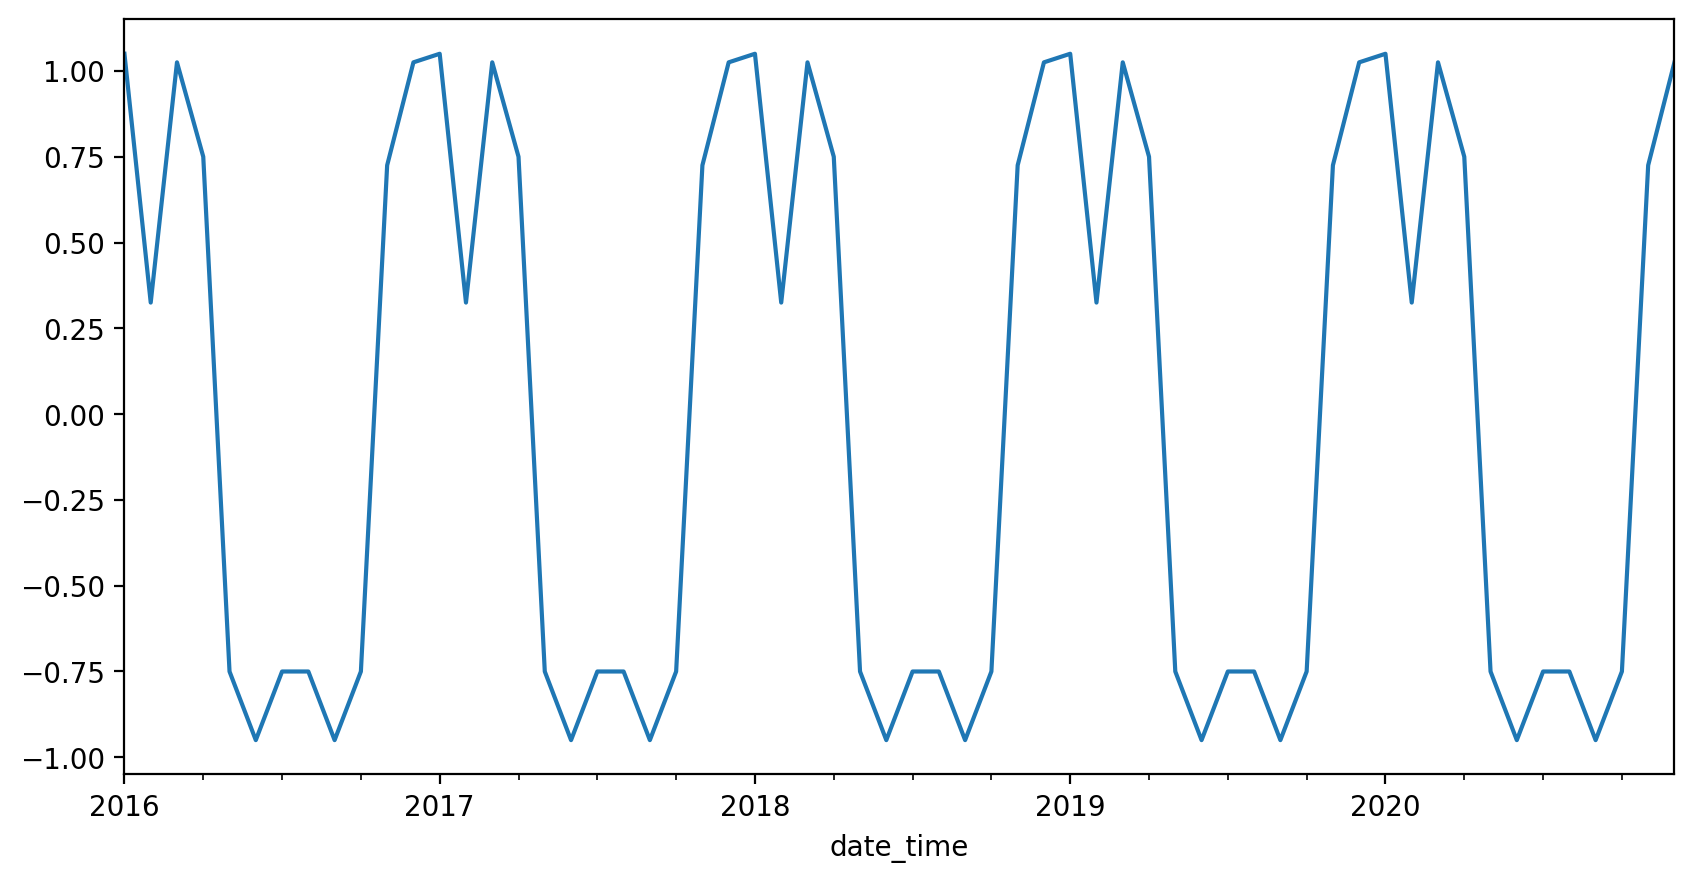

In [11]:
result.seasonal.plot()

<AxesSubplot:xlabel='date_time'>

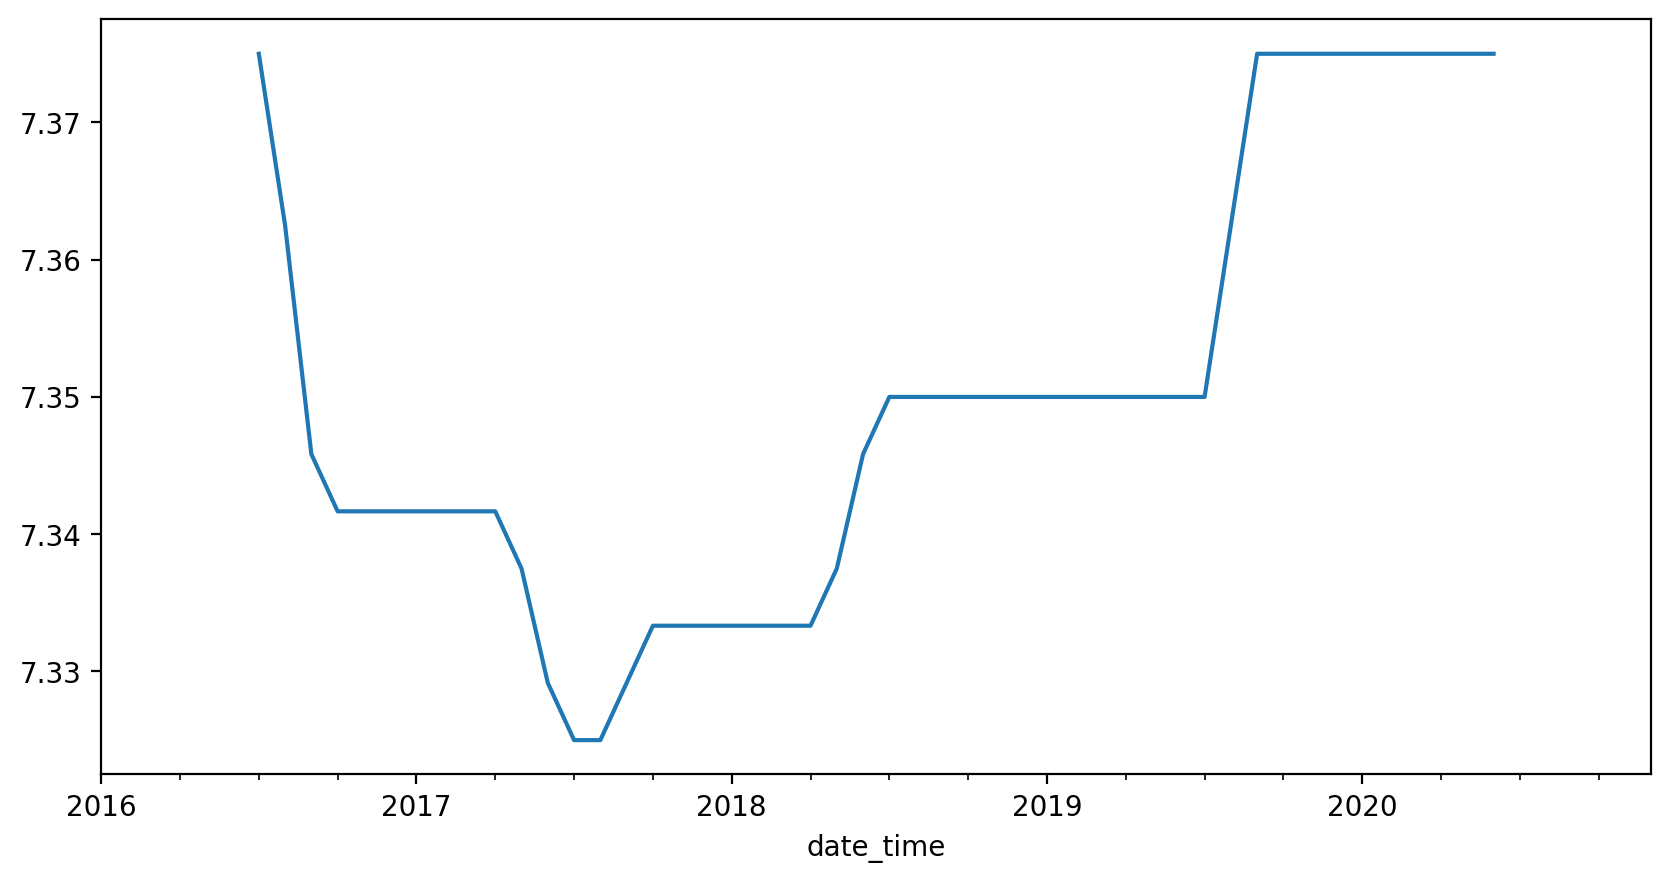

In [13]:
result.trend.plot()

Text(0.5, 1.0, 'Тренд изменения ТВП по участку: КС Пуровская – КС Правохеттинская: Вход КС Пуровская')

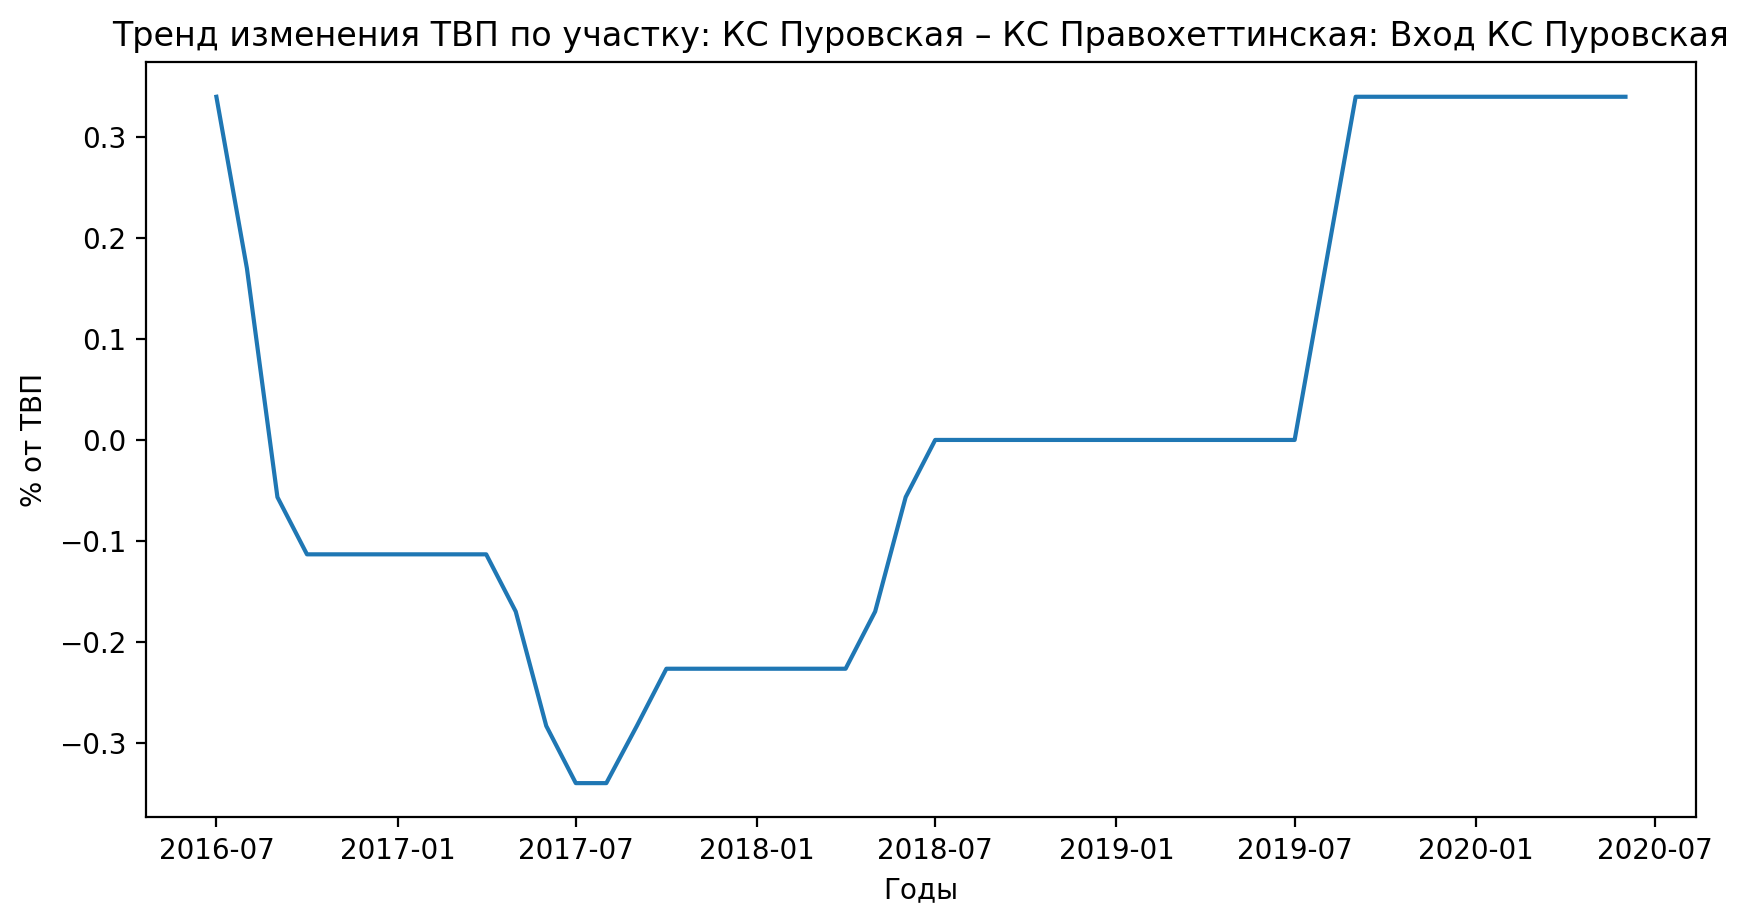

In [23]:
plt.plot((result.trend/result.trend.mean()-1)*100)
plt.xlabel('Годы')
plt.ylabel('% от ТВП')
plt.title(f'Тренд изменения ТВП по участку: {df["line_name"][1]}')

In [26]:
len(df['line_name'].unique())

352

In [33]:
result.trend.describe()

count    48.000000
mean      7.350000
std       0.016034
min       7.325000
25%       7.337500
50%       7.350000
75%       7.362500
max       7.375000
Name: trend, dtype: float64

In [37]:
result.trend.describe()['std']

0.01603409487877506

In [48]:
err_list = []
critical_lines = pd.DataFrame(columns=['Line', 'TVP_fall_%'])
for l_name in df['line_name'].unique():
    y = df.loc[((df['line_name']==l_name) &
             (df.date_time.dt.year > 2015))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
    y = y.set_index('date_time')
    y = pd.Series(y['tvp_without_rr'].values, index=y.index)

    try:
        result = seasonal_decompose(y, model='additive')
    except:
        err_list.append(l_name)
    
    if result.trend.describe()['std'] > 0.1:
#         print(f'{l_name}: {result.trend.describe()["std"]}')
        critical_lines.loc[len(critical_lines)] = [l_name, result.trend.describe()["std"]*100]
print('\n')
print('* '*20)
print(err_list)



* * * * * * * * * * * * * * * * * * * * 
['Гос. граница РФ – Калининградское ПХГ: Гос. граница РФ', 'Гос. граница РФ – Калининградское ПХГ: Вход Калининградского ПХГ']


Соберем итоговую таблицу с участками, где падение ТВП за наблюдаемый период по выделенному тренду составило более 10:

In [49]:
critical_lines.sort_values(by=['TVP_fall_%'], ascending=False)

,Line,TVP_fall_%
43,КС Грязовец – ГИС Иматра: Справочно: Вход КС Г...,330.640091
36,КС Грязовец – ГИС Иматра: Справочно: Граница О...,303.803415
34,КС Грязовец – ГИС Иматра: Справочно: Вход КС Г...,226.912153
90,"КС Грязовец - ГИС Портовая: Граница ООО ""ГТ Ух...",226.748370
38,КС Грязовец – ГИС Иматра: Справочно: ГИС Портовая,201.092141
...,...,...
40,КС Грязовец - ГИС Портовая: Вход КС Грязовец (...,10.315194
48,КС Ал.Гай – КС Петровск: Реверс: вход КС Ал.Гай,10.290489
103,КС Валдай – КС Новгород: Выход КС Новгород,10.243233
79,КС Минск – ГИС Котловка: Выход КС Минск,10.027662


Посмотрим на участок с самым большим падением

In [56]:
cr_line = critical_lines.sort_values(by=['TVP_fall_%'], ascending=False).loc[43, 'Line']

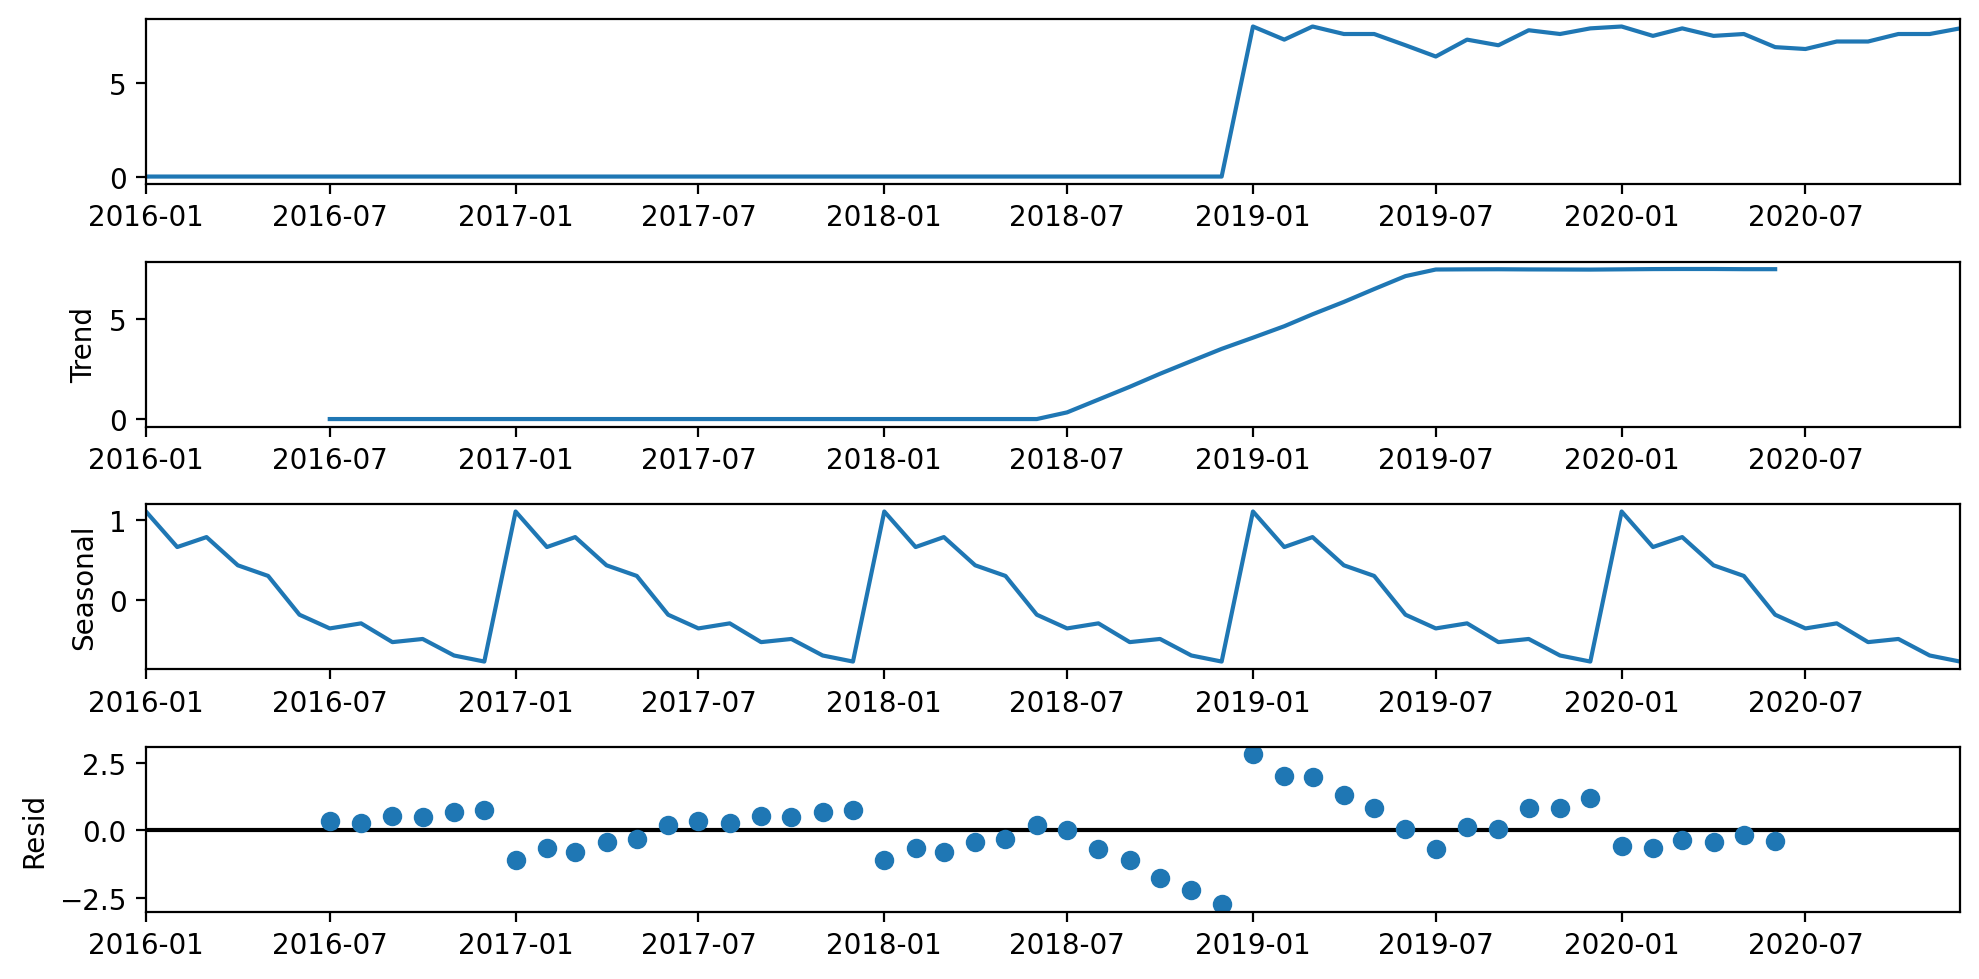

In [57]:
y = df.loc[((df['line_name']==cr_line) &
             (df.date_time.dt.year > 2015))]\
        [['tvp_without_rr', 'date_time']].fillna(0)
y = y.set_index('date_time')
y = pd.Series(y['tvp_without_rr'].values, index=y.index)

result = seasonal_decompose(y, model='additive')
result.plot();

Судя по всему проблема в недостатке данных. Нужно добавить дополнительную фильтрацию, что бы ситуация когда у нас нет данных не приводила к большим ошибкам.

**Работать только с временным интервалом, когда данные есть!!!**